In [1]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 73.3 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0


In [2]:
import numpy as np
import random
import torch
import torch.nn as nn  
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

In [3]:
env = gym.make('Acrobot-v1')
env._max_episode_steps = 500
env.seed(0)
state_shape = env.observation_space.shape[0]
n_actions = env.action_space.n

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


In [4]:
state = env.reset()
action = env.action_space.sample()
next_state, reward, done, info = env.step(action)

In [5]:
print(state_shape)
print(n_actions)

6
3


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Qnetwork1(nn.Module):
  def __init__(self, state_size, action_size, seed, fc1_size=128, fc2_size=64):
    super(Qnetwork1, self).__init__()
    self.seed = torch.manual_seed(seed)
    self.fc1 = nn.Linear(state_size, fc1_size)
    self.fc2 = nn.Linear(fc1_size, fc2_size)
    self.fc3 = nn.Linear(fc2_size, action_size)

  def forward(self, state):
    x = F.relu(self.fc1(state))
    x = F.relu(self.fc2(x))
    return self.fc3(x)

In [7]:
BUFFER_SIZE = int(1e5)   
BATCH_SIZE = 64         
GAMMA = 0.99            
LR = 1e-4               
UPDATE_EVERY = 20

In [8]:
import random
import numpy as np
from collections import namedtuple, deque

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class ReplayBuffer():

  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.batch_size = batch_size
    self.seed = random.seed(seed)
    self.memory = deque(maxlen = buffer_size)
    self.experience = namedtuple('Experience', field_names = ['state', 'action', 'reward', 'next_state', 'done'])

  def add(self, state, action, reward, next_state, done):
    exp = self.experience(state, action, reward, next_state, done)
    self.memory.append(exp)

  def sample(self):
    experiences = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
    actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
    rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
    next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
    dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

    return states, actions, rewards, next_states, dones

  def __len__(self):
    return len(self.memory)

In [9]:
class Agent():

  def __init__(self, state_size, action_size, seed):

    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.qnetwork_local = Qnetwork1(state_size, action_size, seed).to(device)
    self.qnetwork_target = Qnetwork1(state_size, action_size, seed).to(device)

    self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = LR)
    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    self.t_step = 0

  def step(self, state, action, reward, next_state, done):

    self.memory.add(state, action, reward, next_state, done)

    if len(self.memory) > BATCH_SIZE:
      experiences = self.memory.sample()
      self.learn(experiences, GAMMA)

    self.t_step = (self.t_step + 1) % UPDATE_EVERY
    if self.t_step == 0:
      self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

  def act(self, state, eps=0.):

    state = torch.from_numpy(state).float().unsqueeze(0).to(device)
    self.qnetwork_local.eval()
    with torch.no_grad():
        action_values = self.qnetwork_local(state)
    self.qnetwork_local.train()

    if random.random() > eps:
        return np.argmax(action_values.cpu().data.numpy())
    else:
        return random.choice(np.arange(self.action_size))

  def learn(self, experiences, gamma):
    
    states, actions, rewards, next_states, dones = experiences
    Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
    Q_expected = self.qnetwork_local(states).gather(1, actions)
    loss = F.mse_loss(Q_expected, Q_targets)

    self.optimizer.zero_grad()
    loss.backward()

    for param in self.qnetwork_local.parameters():
        param.grad.data.clamp_(-1, 1)
        
    self.optimizer.step()


In [25]:
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n

def dqn(agent,n_episodes=10000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
  scores = []  
  scores_window= deque(maxlen=100) 
  eps = eps_start

  for i_episode in range(1, n_episodes+1):
        state = env.reset()
        episode_reward = 0
        done = False
        while not done:
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward

        scores.append(episode_reward)
        scores_window.append(episode_reward)


        eps = max(eps_end, eps_decay*eps) 
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")         
        if i_episode % 100 == 0: 
           print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=-200.0:
           print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
           break
  return [np.array(scores),i_episode]


Episode 71	Average Score: -398.93
Environment solved in -29 episodes!	Average Score: -398.93
0:01:23.955119
Episode 70	Average Score: -398.27
Environment solved in -30 episodes!	Average Score: -398.27
0:01:24.072895
Episode 74	Average Score: -398.99
Environment solved in -26 episodes!	Average Score: -398.99
0:01:25.826691


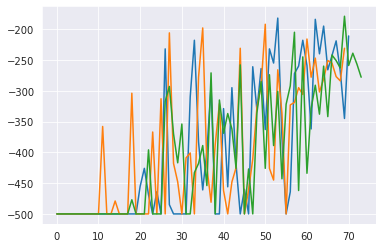

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

env = gym.make('Acrobot-v1')
env._max_episode_steps = 500
env.seed(0)
state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n
n_episodes = []
n_time = []
all_scores = []

for i in range(10):

  begin_time = datetime.datetime.now()
  agent = Agent(state_size=state_shape,action_size = action_shape,seed = 0)
  output = dqn(agent)
  scores = output[0]
  all_scores.append(scores)
  n_episodes.append(output[1])
  time_taken = datetime.datetime.now() - begin_time
  n_time.append(time_taken)
  sns.set_style('darkgrid')
  print(time_taken)

In [23]:
def plot_mean_and_variance(mean_array, std_array):
    x = np.arange(len(mean_array))
    plt.plot(x, mean_array, label='Mean')
    plt.fill_between(x, mean_array - std_array, mean_array + std_array, alpha=0.2, label='Standard Deviation')
    plt.xlabel('Episodes')
    plt.ylabel('Reward')

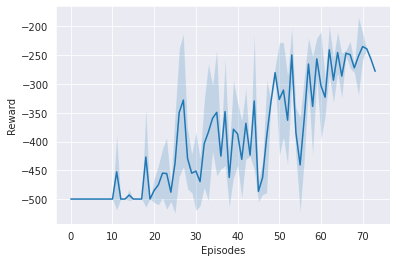

In [24]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

y, error = tolerant_mean(all_scores)
plot_mean_and_variance(y, error)